<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Graphs and Networks</h1>
        <h1>Social Structure</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

import tqdm as tq
from tqdm.notebook import tqdm
import os

import networkx as nx
import random
import wget

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 8.12.2

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: c651710cbd33e41181173979762bc5df0ee7e746

json      : 2.0.9
numpy     : 1.24.2
watermark : 2.1.0
matplotlib: 3.7.1
tqdm      : 4.62.0
pandas    : 1.5.3
networkx  : 3.1
wget      : 3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Load the Higgs Reply Network

In [4]:
filename = 'data/social_network.edgelist.gz'
url = 'https://snap.stanford.edu/data/higgs-reply_network.edgelist.gz'

if not os.path.exists(filename):
    progress_bar = None

    def tqdm_bar(current, total, width=80):
        global progress_bar

        if progress_bar is None:
            progress_bar = tqdm(total=total, unit='iB')
        
        progress_bar.update(current)
    
    print('Downloading File')
    wget.download(url, filename, bar=tqdm_bar)

reply = pd.read_csv(filename, sep=' ', 
                    header=None, names=['node_i', 'node_j', 'weight'])

Create the graph

In [5]:
G = nx.DiGraph()
G.add_edges_from(reply[['node_i', 'node_j']].values)

In [6]:
G.number_of_nodes()

38918

In [7]:
G.number_of_edges()

32523

Extract the GCC 

In [8]:
components = list(nx.components.weakly_connected_components(G))
comp_sizes = [len(comp) for comp in components]
largest_component = np.argmax(comp_sizes)

In [9]:
GCC = nx.subgraph(G, components[largest_component])

In [10]:
GCC.number_of_nodes()

12839

In [11]:
GCC.number_of_edges()

14944

# Clustering Coefficient

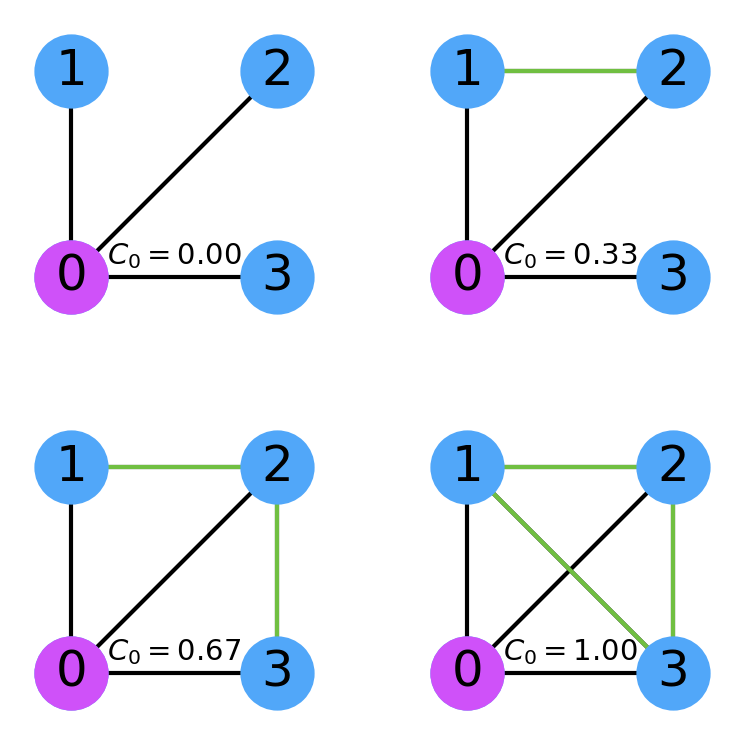

In [12]:
fig, ax_lst = plt.subplots(2,2, figsize=(3, 3))
ax_lst = np.array(ax_lst).flatten()

G_small = nx.Graph()
G_small.add_nodes_from([0, 1, 2, 3])
G_small.add_edges_from([(0, i) for i in range(1, 4)])

edge_seq = [[], [1, 2], [2, 3], [1, 3]]

pos = {
    0: (0, 0),
    1: (0, 1),
    2: (1, 1),
    3: (1, 0)}

for i in range(4):
    if i > 0:
        G_small.add_edge(*edge_seq[i])
    
    nx.draw(G_small, pos, ax=ax_lst[i], node_color=colors[0])
    nx.draw_networkx_nodes(G_small, pos, [0], ax=ax_lst[i], node_color=colors[1])
    nx.draw_networkx_labels(G_small, pos, ax=ax_lst[i])
    
    C = nx.clustering(G_small)[0]
    ax_lst[i].text(0.5, 0.1, r"$C_0=%1.2f$" % C, fontsize=7, ha='center', va='center')

    
    if i>0:
        nx.draw_networkx_edges(G_small, pos, list(edge_seq[1:i+1]), ax=ax_lst[i], edge_color=colors[2])
    
    ax_lst[i].axis('off')
    ax_lst[i].set_xlim(-0.2, 1.2)
    ax_lst[i].set_ylim(-0.2, 1.2)

fig.tight_layout()

We compute the clustering of each node using NetworkX

In [13]:
clustering = dict(nx.clustering(GCC))

the average clustering is then

In [14]:
np.mean(list(clustering.values()))

0.006741158501397098

Which we can confirm with NetworkX

In [15]:
cmean = nx.average_clustering(GCC)
cmean

0.006741158501397098

And compute the degree coefficient of each node

In [16]:
deg = dict(GCC.degree())

In [17]:
avg_clustering_k = {}
count = {}

for node in deg:
    k = deg[node]
    c = clustering[node]
    count[k] = count.get(k, 0) + 1
    
    avg_clustering_k[k] = avg_clustering_k.get(k, 0) + c
    
for k in avg_clustering_k:
    avg_clustering_k[k] /= count[k]

avg_clustering_k = pd.DataFrame(np.array(list(avg_clustering_k.items())))
avg_clustering_k.columns = ['k', 'ck']
avg_clustering_k.sort_values('k', inplace=True)

Now we plot the clustering coefficient as a function of the degree

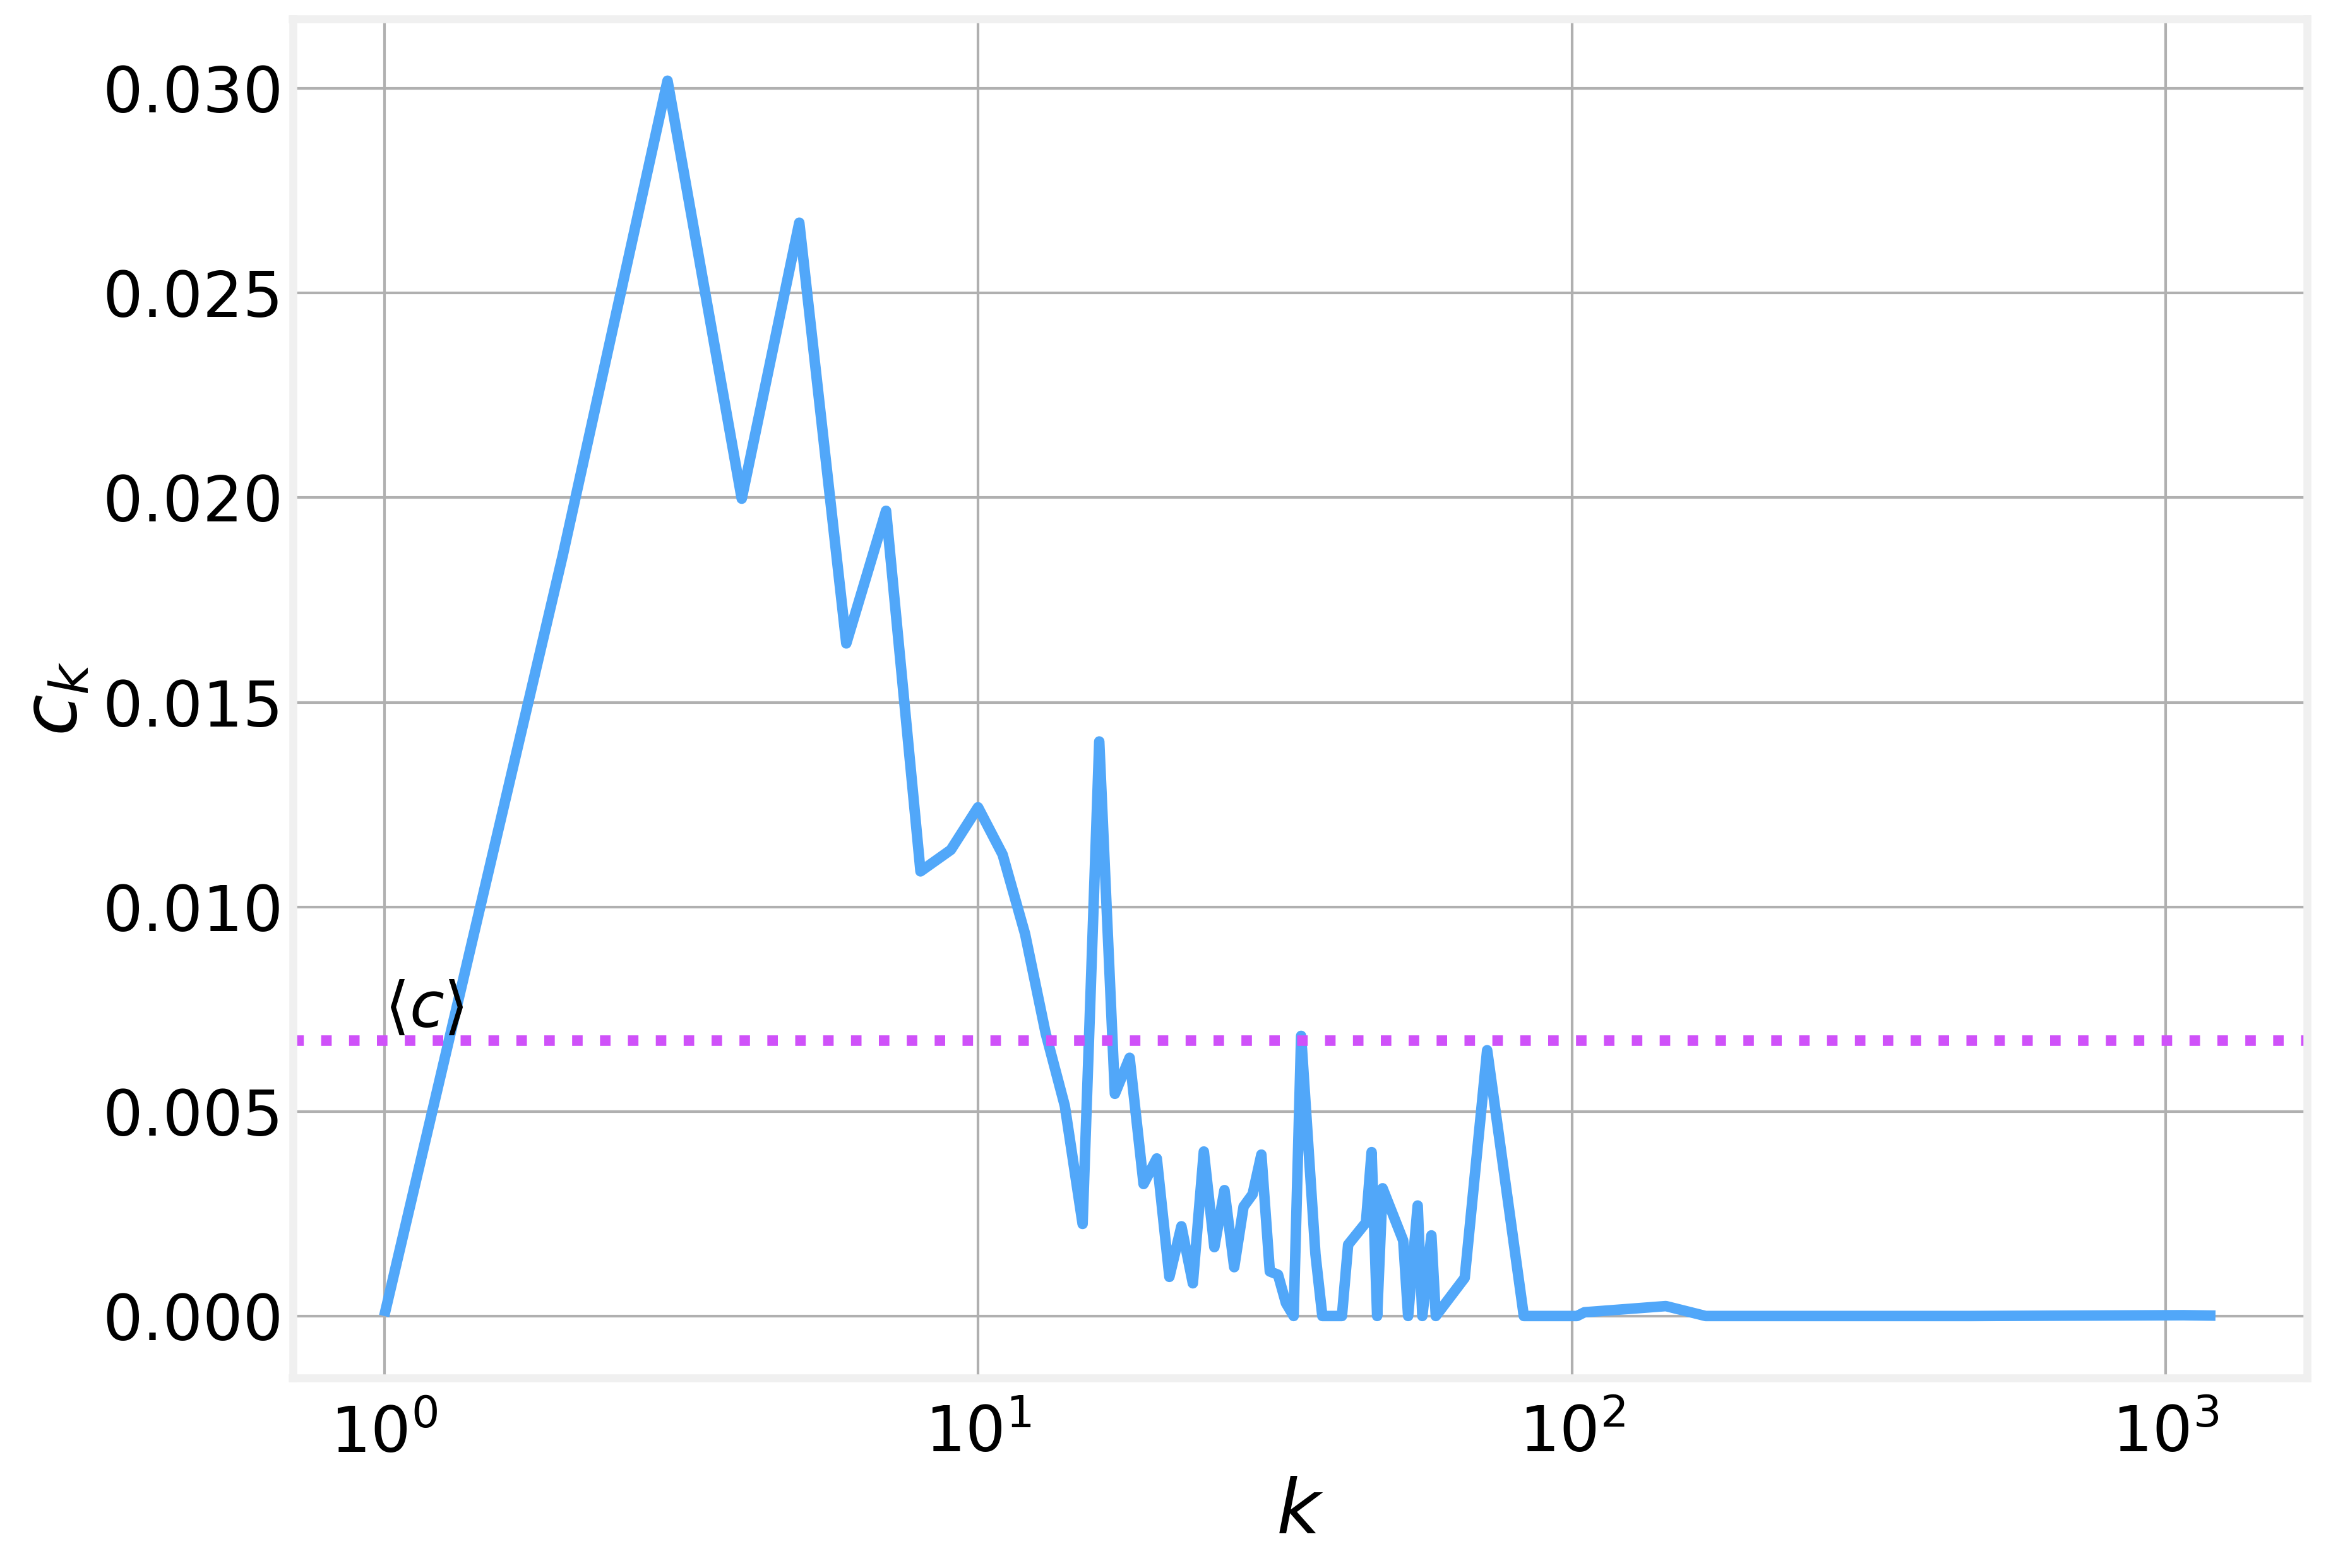

In [18]:
ax = avg_clustering_k.plot(x='k', y='ck', legend=None)
ax.set_ylabel(r'$c_k$')
ax.set_xlabel(r'$k$')
ax.set_xscale('log')
ax.axhline(y=cmean, color=colors[1], linestyle=':')
ax.text(x=1, y=cmean, s=r'$\langle c\rangle$', verticalalignment='bottom')
ax.tick_params(axis='x', which='major', pad=10)

As we can see, some nodes have much higher clustering coefficient than the average, specially for smaller degrees indicating that they are part of denser areas of the network.

# Community Structure

In [19]:
SCC = nx.strongly_connected_components(GCC)

In [20]:
comps = [(comp, len(comp)) for comp in SCC]

In [21]:
sorted_comps = sorted(comps, key=lambda x:x[1], reverse=True)

In [22]:
SCC = nx.subgraph(GCC, sorted_comps[0][0])

In [23]:
SCC.number_of_nodes()

322

In [24]:
SCC.number_of_edges()

708

And visualize it

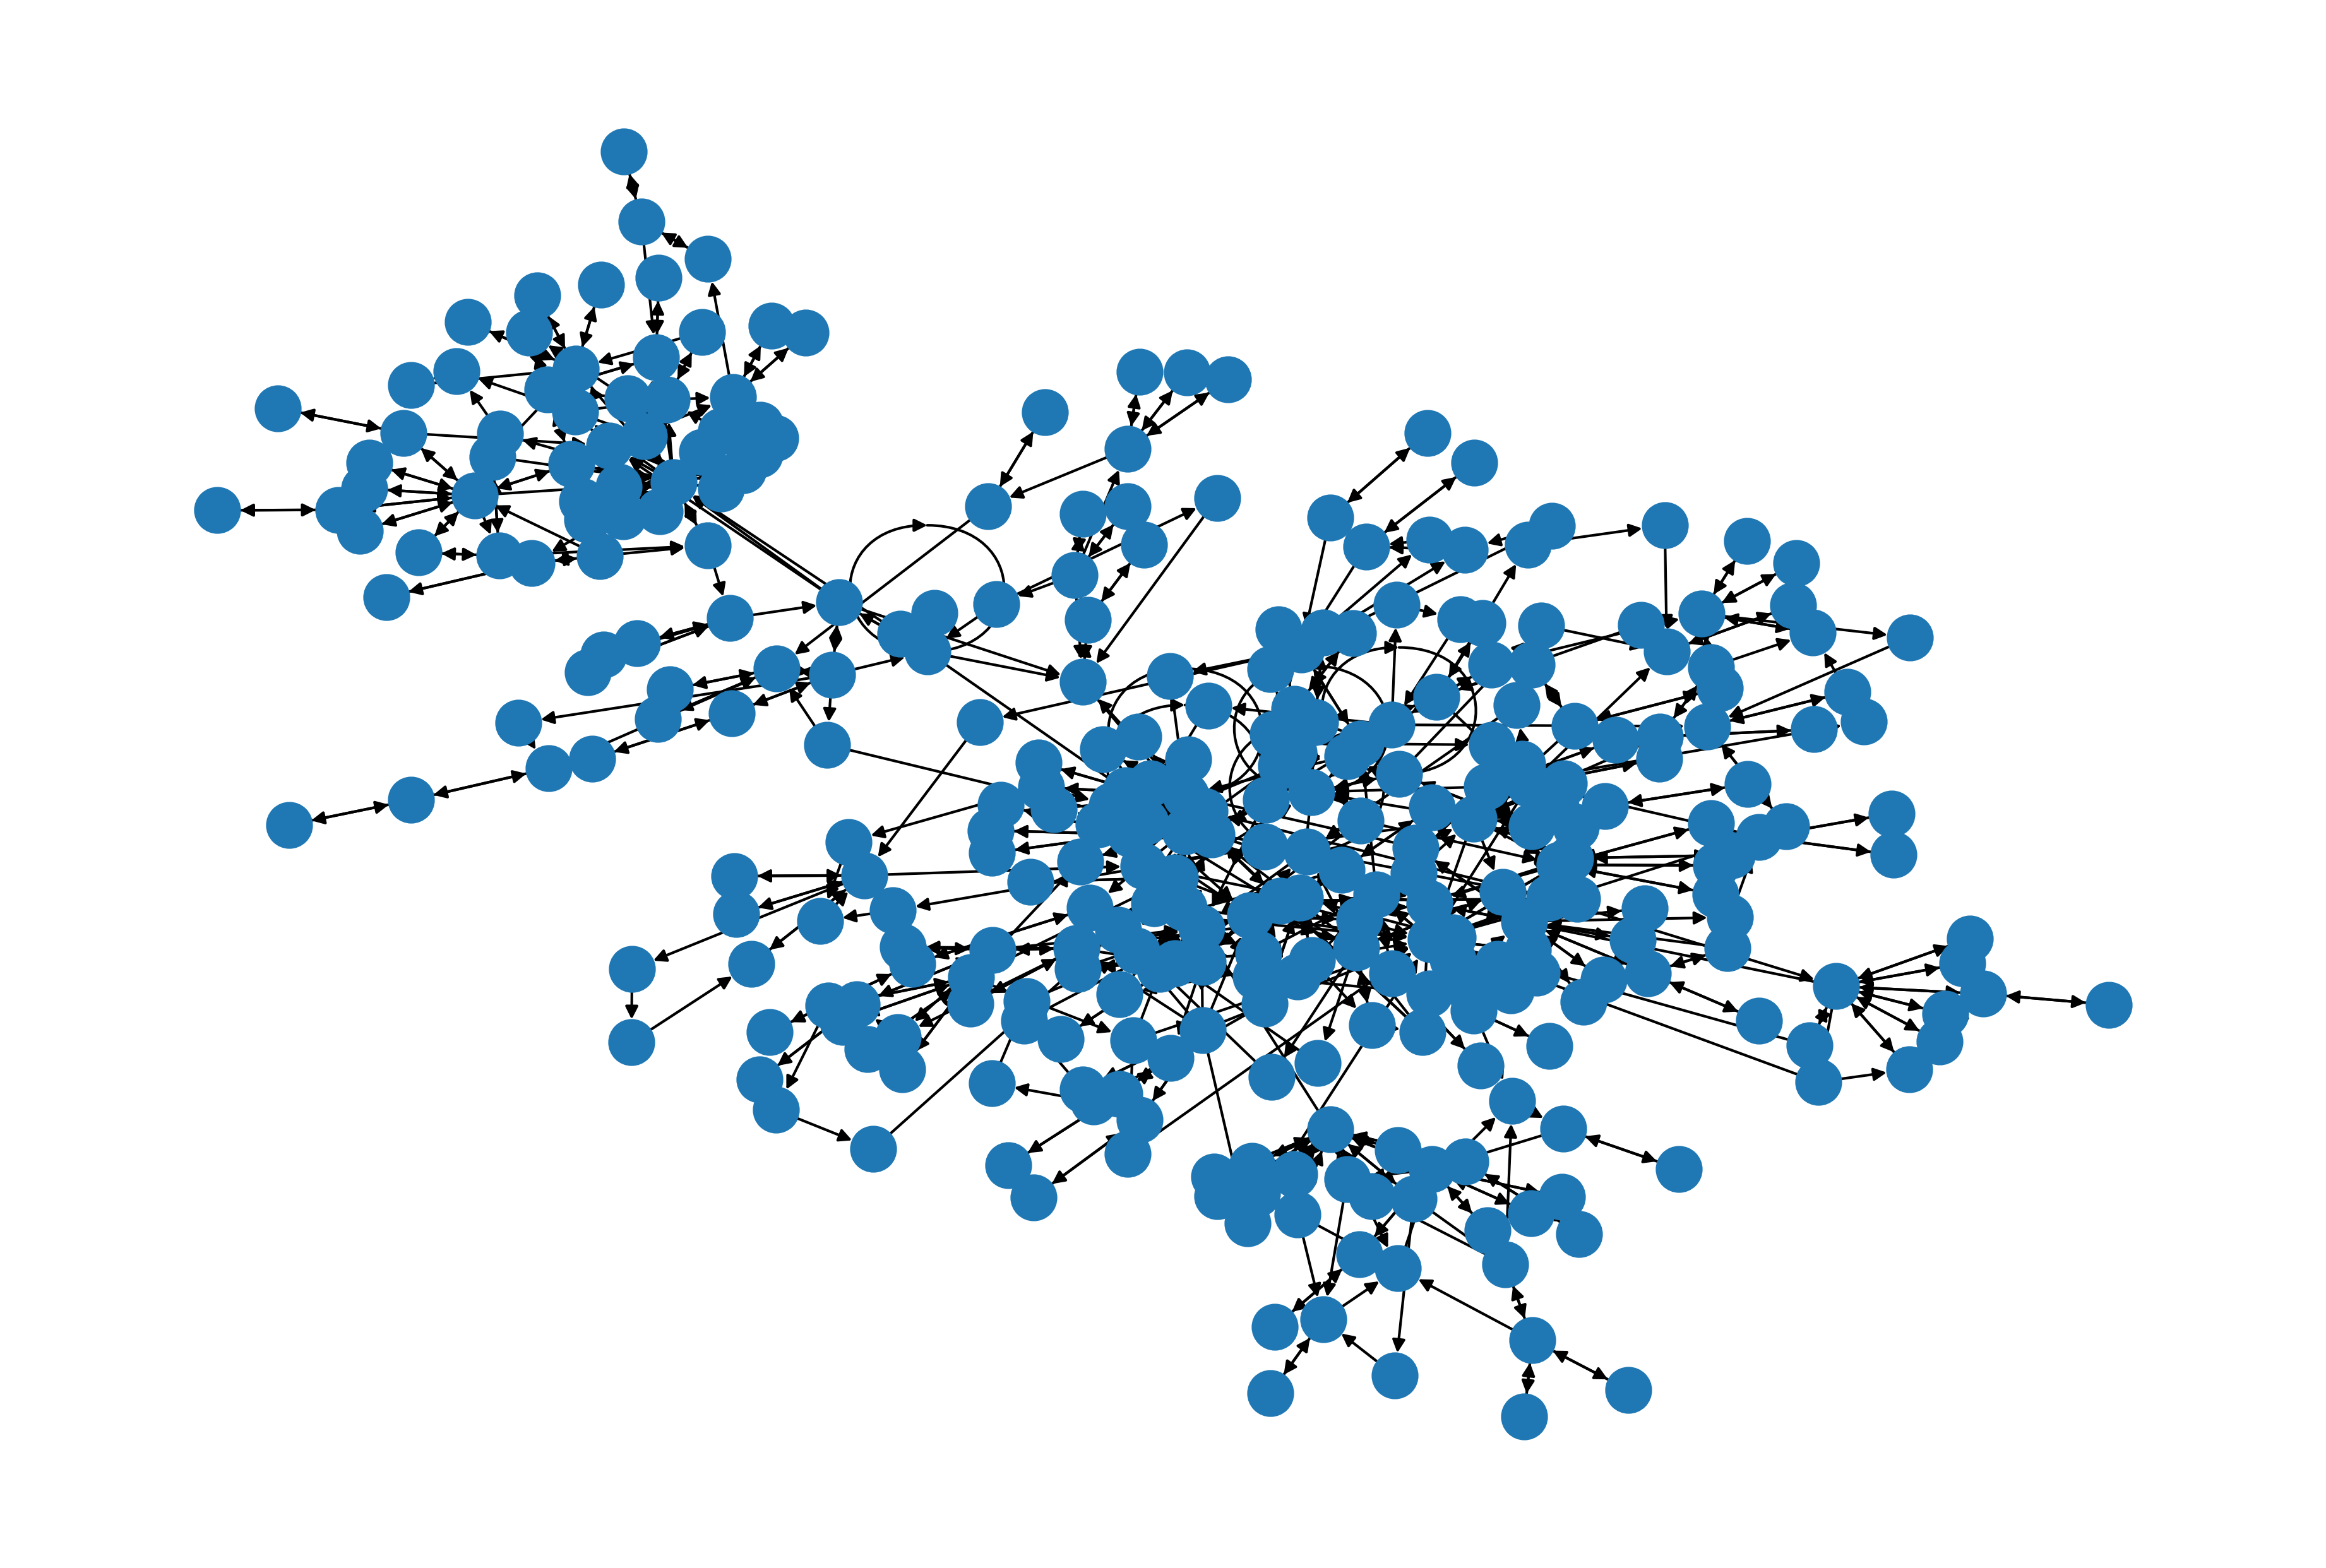

In [25]:
np.random.seed(123)
layout = nx.layout.kamada_kawai_layout(SCC, weight='weight')
fig, ax = plt.subplots(1)
nx.draw(SCC, pos=layout, ax=ax)

In [26]:
communities = nx.community.girvan_newman(SCC, 
                                   lambda G: max(nx.edge_betweenness_centrality(G, weight='weight').items(), 
                                                 key=lambda x:x[1])[0])
communities = list(communities)

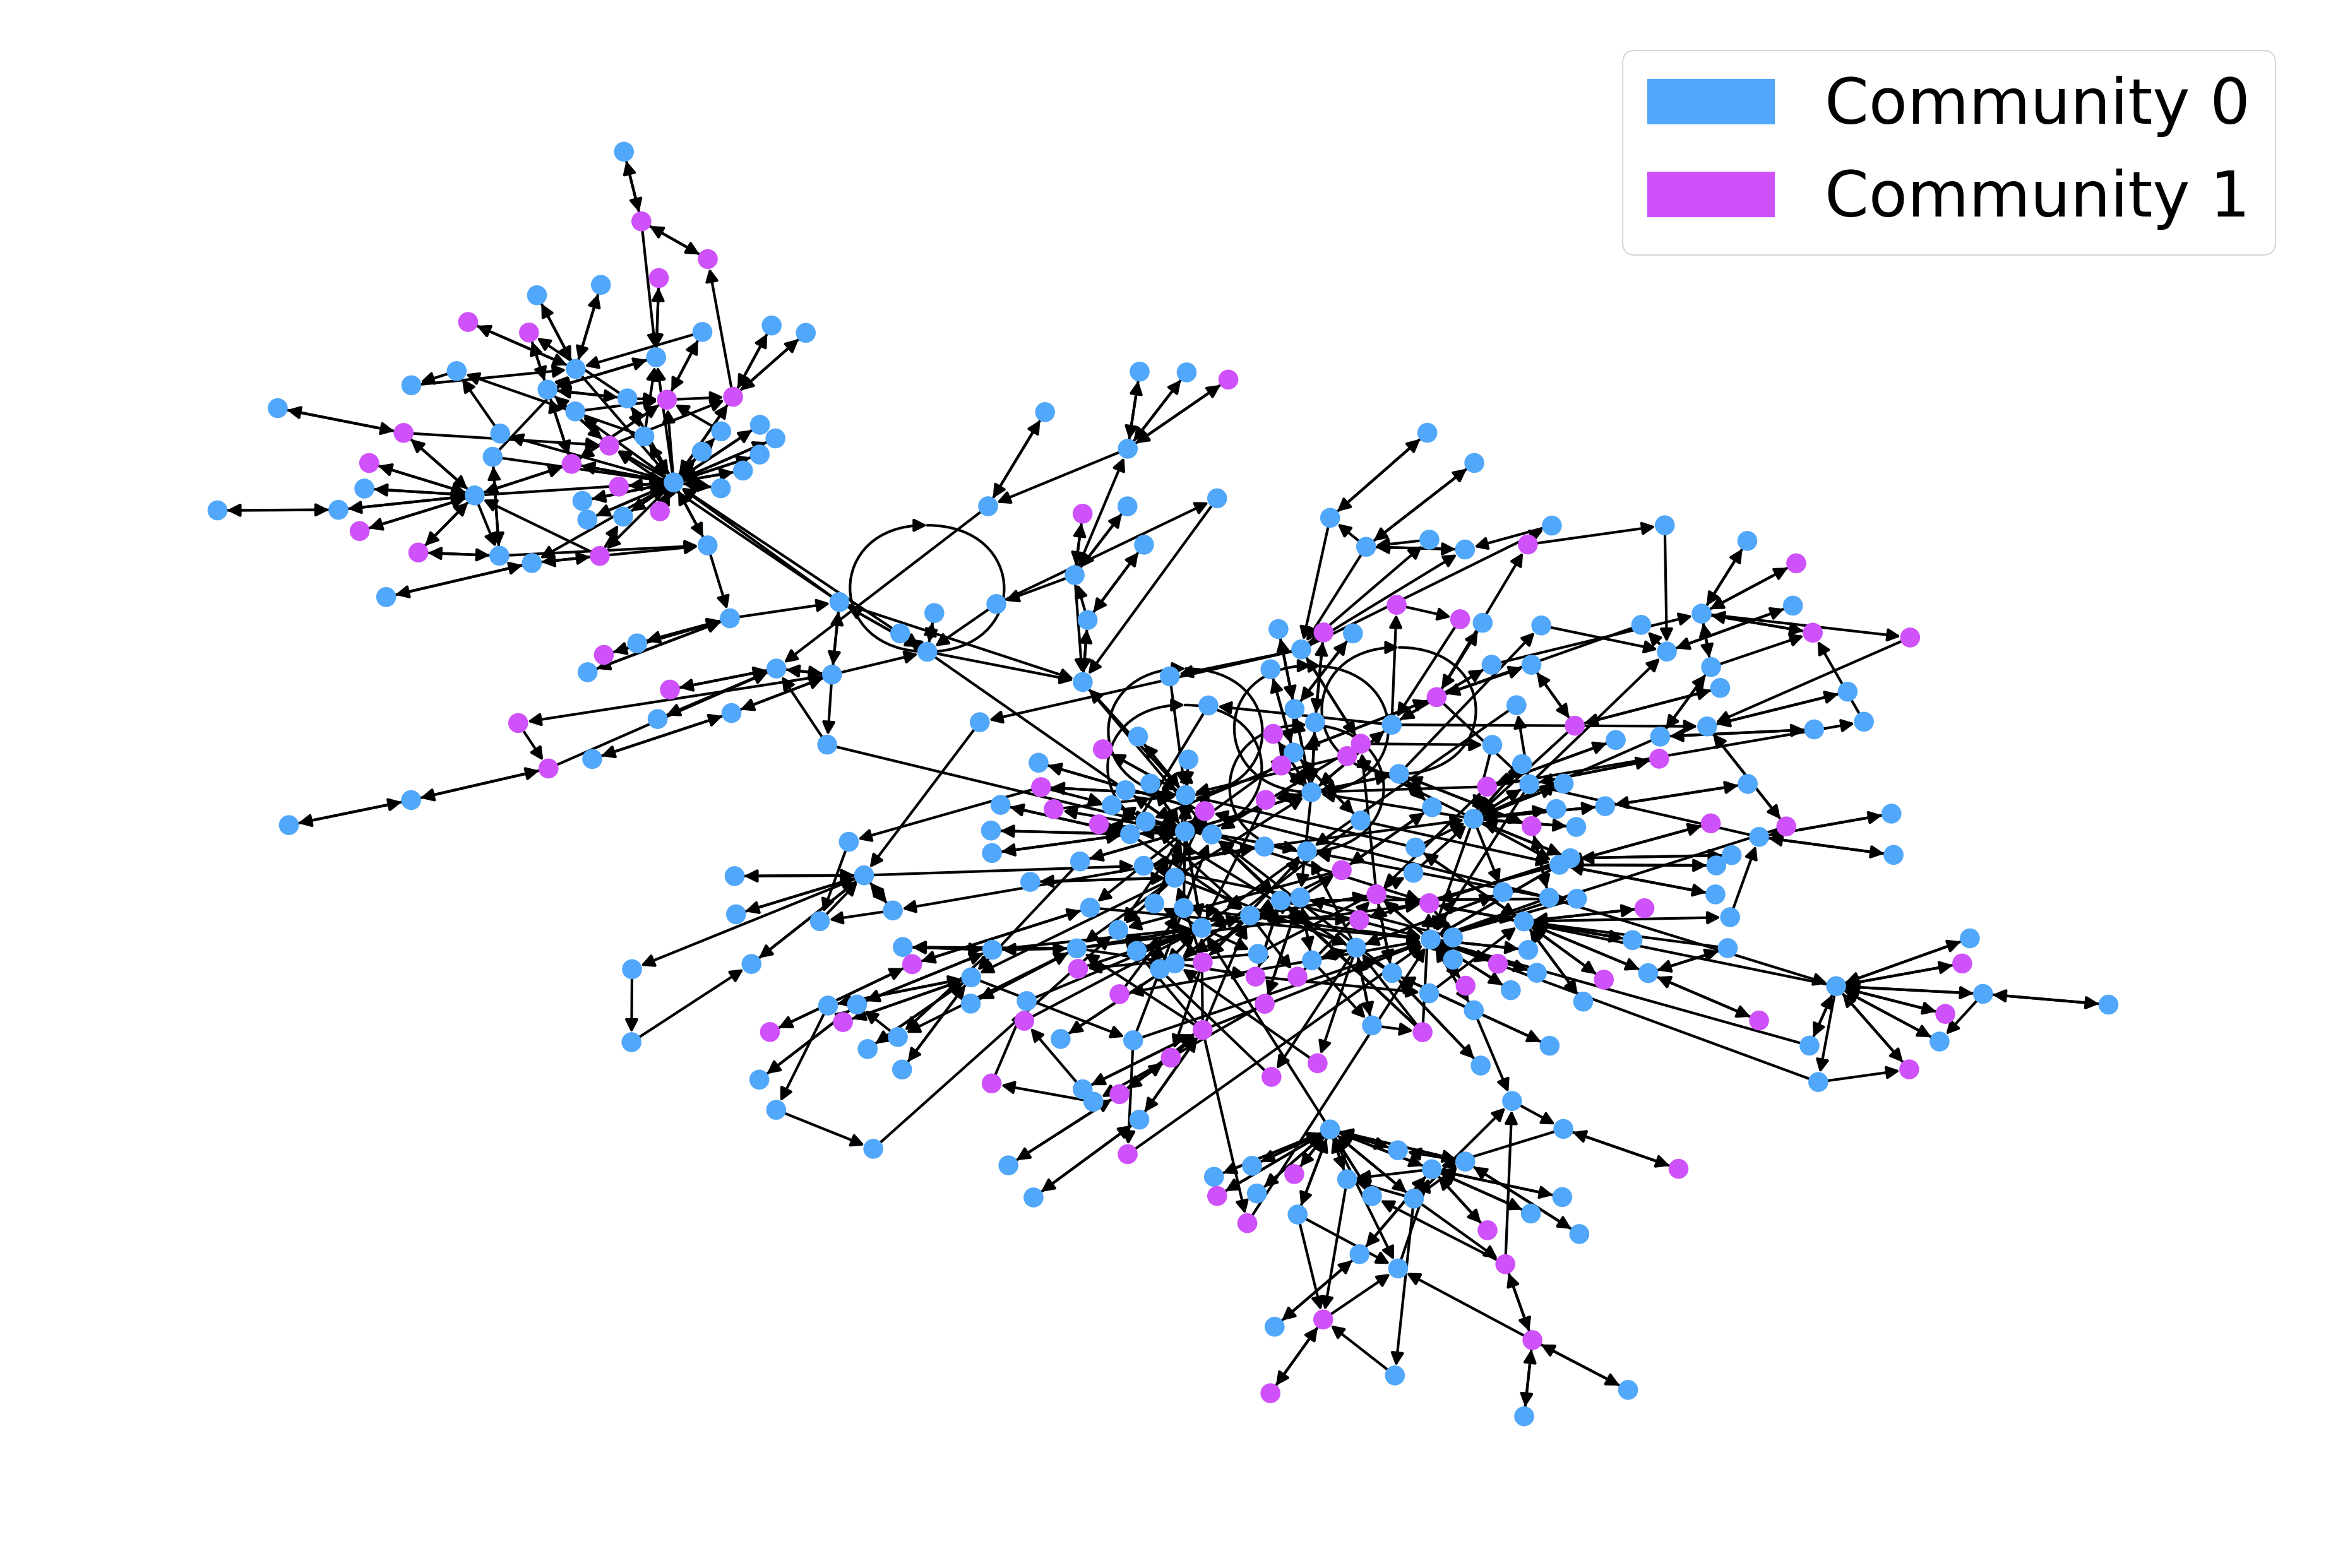

In [27]:
node_groups = communities[0]
leg_handles = []

# plot the communities
color_map = {}
for i in range(len(node_groups)):
    patch = mpatches.Patch(color=colors[i], label='Community %u' % i)
    leg_handles.append(patch)
    
    for node in node_groups[i]:
        color_map[node] = colors[i]
        
color_map = [color for node, color in sorted(color_map.items())]

fig, ax = plt.subplots(1)
nx.draw(SCC, pos=layout, node_color=color_map, with_labels=False, ax=ax, node_size=50)
ax.legend(handles=leg_handles)

# Modularity

In [28]:
communities = nx.community.girvan_newman(SCC, 
                                   lambda G: max(nx.edge_betweenness_centrality(G, weight='weight').items(), 
                                                 key=lambda x:x[1])[0])

In [29]:
N = SCC.number_of_nodes()

In [30]:
modularity = {}
comms = {}

for i in tqdm(range(2, N), total=N-2):
    # Extract community structure from iterator
    comms[i] = next(communities)
    
    # Compute the modularity
    modularity[i] = nx.community.modularity(SCC, comms[i])

  0%|          | 0/320 [00:00<?, ?it/s]

In [31]:
modularity = pd.DataFrame(modularity.items()).set_index(0)

In [32]:
max_modularity = int(modularity.idxmax())

Text(0, 0.5, 'Modularity (Q)')

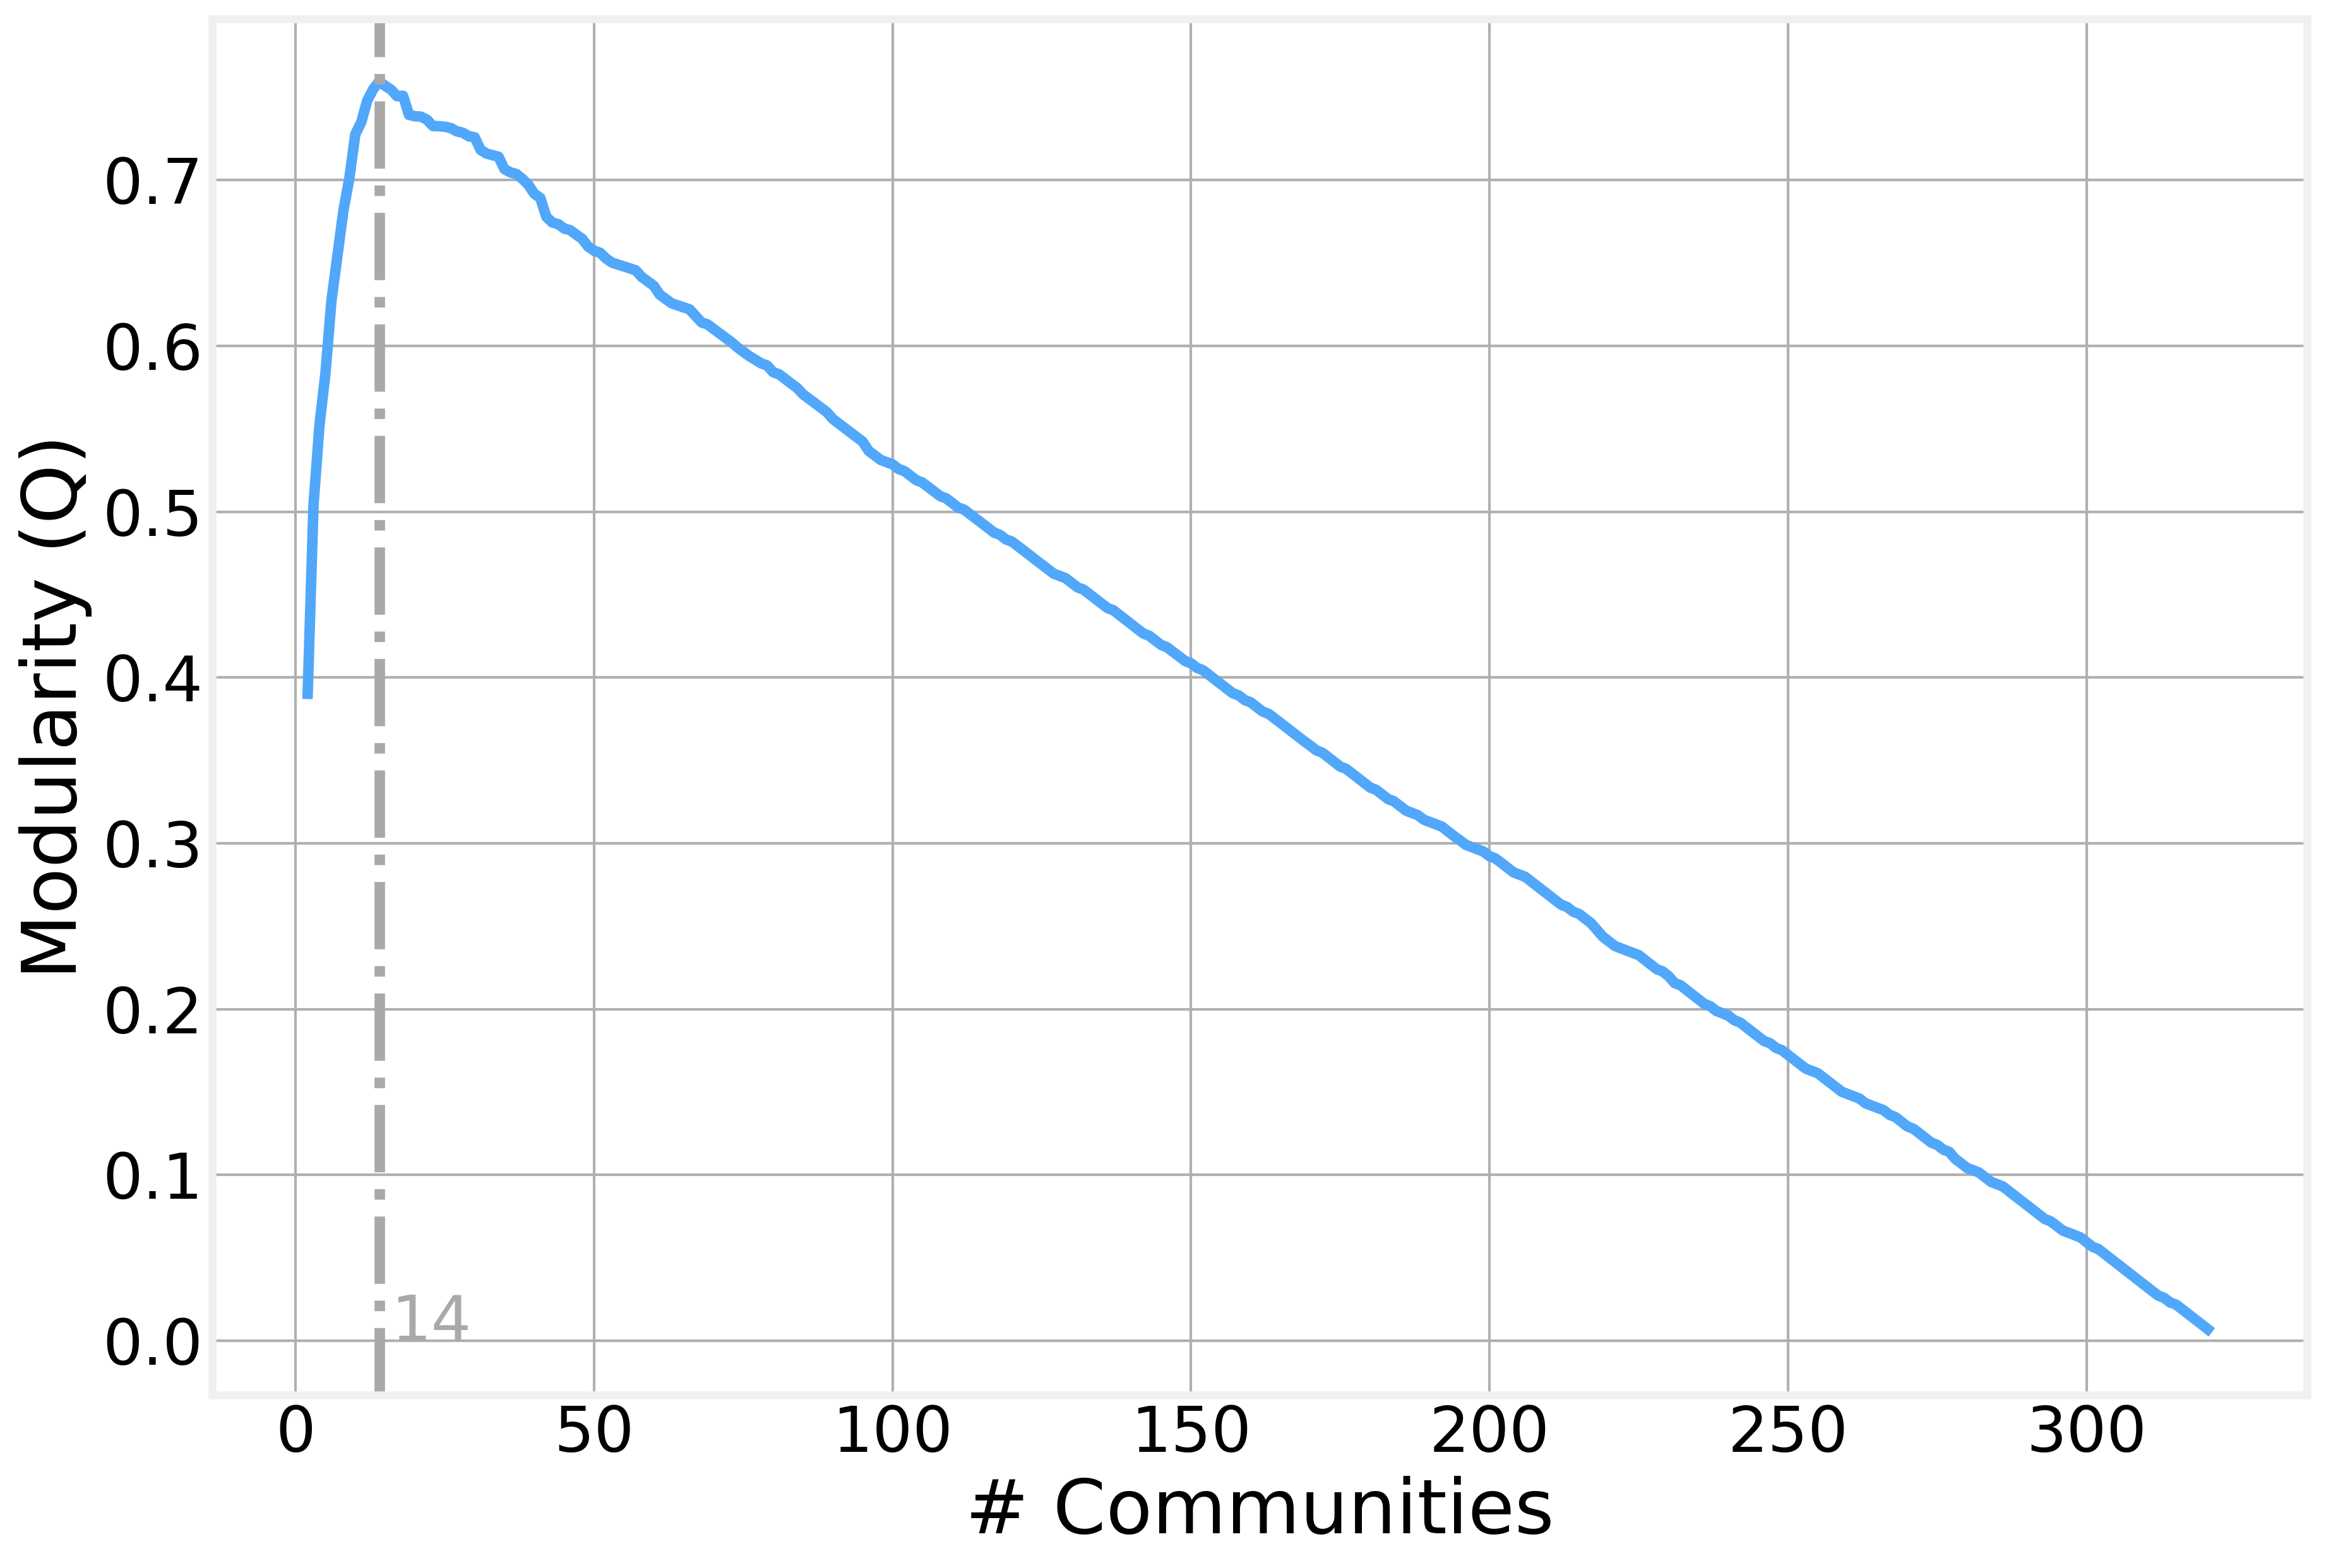

In [33]:
ax = modularity.plot(legend=False)
ax.axvline(x=max_modularity, linestyle='-.', color='darkgray')
ax.text(s=max_modularity, x=max_modularity+2, y=0, color='darkgray')
ax.set_xlabel('# Communities')
ax.set_ylabel('Modularity (Q)')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>